# Introduction

In this notebook I try to let a Perceptron - implemented in PyTorch - learn to classify N (e.g. N=5) different patterns that differ only in some small details.

# Generating example data

Here I generate N training patterns that differ only in some small region.

In [1]:
import torch

S = 6
N_base_patterns = 5
N_training_patterns_per_base_pattern = 100
N_total_training_patterns = N_base_patterns * N_training_patterns_per_base_pattern

x = torch.zeros(N_total_training_patterns, S**2)
y = torch.zeros(N_total_training_patterns, N_base_patterns)

# generate base patterns
list_base_patterns = []
for base_pattern_nr in range(N_base_patterns):
    new_base_pattern = torch.randn(2,2) * 0.1
    print(new_base_pattern)
    list_base_patterns.append( new_base_pattern )

# generate training patterns of size (S,S)
pattern_nr = 0
for base_pattern_idx in range(N_base_patterns):
    
    # get the next base pattern
    base_pattern = list_base_patterns[base_pattern_idx]
    
    # create trainings patterns with the base pattern in the center
    for nr_training_pattern in range(N_training_patterns_per_base_pattern):
        
        # generate random input pattern with defined center values
        pattern = torch.randn(S, S)
        pattern[S//2-1:S//2+1, S//2-1:S//2+1 ] = base_pattern
        #print(pattern)
        #print(pattern.view(S**2))
        
        # store new input pattern
        x[pattern_nr,:] = pattern.view(S**2)
        
        # generate new target pattern
        one_hot_vec = torch.zeros(N_base_patterns)
        one_hot_vec[base_pattern_idx] = 1
        #print(one_hot_vec)
        
        # store target pattern
        y[pattern_nr,:] = one_hot_vec
        
        pattern_nr += 1

tensor([[ 0.1237, -0.0566],
        [ 0.0327, -0.1240]])
tensor([[-0.0562,  0.0253],
        [ 0.0838, -0.2146]])
tensor([[-0.0296, -0.0530],
        [ 0.1241,  0.0431]])
tensor([[ 0.0086, -0.0052],
        [-0.0425,  0.0843]])
tensor([[ 0.0053, -0.0625],
        [ 0.0090, -0.0031]])


In [2]:
x.shape

torch.Size([500, 36])

In [3]:
y.shape

torch.Size([500, 5])

In [4]:
#for i in range(0,100):
 #   print(x[i])

# Shuffle example data

In [5]:
matrix = torch.tensor([[1., 2., 3.],[4., 5., 6.],[7, 8, 9]])
print("Original Matrix:\n", matrix)

Original Matrix:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [6]:
r = torch.tensor([1, 0, 2])

In [7]:
matrix2 = matrix[r, :] # shuffles rows
matrix2

tensor([[4., 5., 6.],
        [1., 2., 3.],
        [7., 8., 9.]])

In [8]:
torch.randperm(3)

tensor([2, 0, 1])

In [9]:
matrix2 = matrix[torch.randperm(3), :] # shuffles rows
matrix2

tensor([[7., 8., 9.],
        [1., 2., 3.],
        [4., 5., 6.]])

In [10]:
r = torch.randperm(N_total_training_patterns)
x = x[r, :]
y = y[r, :]

In [11]:
x.shape

torch.Size([500, 36])

In [12]:
y.shape

torch.Size([500, 5])

In [13]:
x[0].view(S,S)

tensor([[-1.3597,  0.5327, -0.3627, -1.5491,  0.9362, -1.3758],
        [ 1.3428,  1.5596, -0.6851,  0.8249,  1.0412, -0.0809],
        [-1.9868, -0.3438,  0.0086, -0.0052, -0.2876, -1.0565],
        [ 1.3202, -1.0102, -0.0425,  0.0843,  1.0791,  0.3613],
        [ 1.0903,  1.7652, -0.6553,  2.0992,  0.6211, -0.5079],
        [-0.1331,  0.9848, -0.0364,  1.2708,  1.1292, -1.1389]])

In [14]:
y[0]

tensor([0., 0., 0., 1., 0.])

In [15]:
x[1].view(S,S)

tensor([[ 0.5009,  0.2851,  0.6736, -0.3560, -1.3948, -0.6606],
        [-0.8988, -1.6524,  1.1920,  1.4805,  0.4013, -2.0024],
        [-2.6372, -0.0571, -0.0296, -0.0530,  0.5280,  1.1623],
        [ 0.6830, -0.1201,  0.1241,  0.0431,  0.5684, -0.9306],
        [-0.4524, -0.8493, -1.4346, -0.2620,  1.5562, -1.3662],
        [-2.2725, -0.2893,  0.8302,  1.7105,  0.6588,  3.1339]])

In [16]:
y[1]

tensor([0., 0., 1., 0., 0.])

# Split example data intro train and test data

In [17]:
x.shape

torch.Size([500, 36])

In [18]:
y.shape

torch.Size([500, 5])

In [19]:
train_ratio = 0.8
train_N = int(train_ratio * x.shape[0])
train_N

400

In [20]:
x_train = x[:train_N]
y_train = y[:train_N]
x_test  = x[train_N:]
y_test  = y[train_N:]

In [21]:
x_train.shape

torch.Size([400, 36])

In [22]:
y_train.shape

torch.Size([400, 5])

In [23]:
x_test.shape

torch.Size([100, 36])

In [24]:
y_test.shape

torch.Size([100, 5])

In [25]:
x_train.dtype

torch.float32

In [26]:
y_train.dtype

torch.float32

# Perceptron-Klasse

In [27]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define a neural net
class MLP(nn.Module):
    def __init__(self, nr_inputs, nr_outputs, use_hidden_layer=False, nr_neurons_hidden1=20):
        super().__init__()
        
        # note: order of generated layers here does not matter!       
        # it is the order of layers in forward() that does matter.
        # see: https://discuss.pytorch.org/t/can-i-change-the-order-of-layers-in-init/105027:
        #
        #  "It doesn’t matter. forward is which defines the real order. 
        #   The only difference is they will be displayed differently 
        #   when you print the model or save it."
        #
        self.use_hidden_layer = use_hidden_layer
        if self.use_hidden_layer:
            self.fc1 = nn.Linear(nr_inputs, nr_neurons_hidden1)
            self.actfunc = torch.nn.ReLU()            
            self.fc2 = nn.Linear(nr_neurons_hidden1, nr_outputs)        
        else:
            self.fc1 = nn.Linear(nr_inputs, nr_outputs)

    def forward(self, input_vec):
        if self.use_hidden_layer:
            x = self.fc1(input_vec)
            x = self.actfunc(x)
            x = self.fc2(x)
        else:
            x = self.fc1(input_vec)
        return x

In [28]:
net = MLP(S**2, N_base_patterns, True)

In [29]:
net.fc1

Linear(in_features=36, out_features=20, bias=True)

In [30]:
net.fc2

Linear(in_features=20, out_features=5, bias=True)

In [31]:
net.fc1.weight.shape

torch.Size([20, 36])

In [32]:
net.fc1.bias.shape

torch.Size([20])

In [33]:
net.fc2.weight.shape

torch.Size([5, 20])

In [34]:
net.fc2.bias.shape

torch.Size([5])

In [35]:
net = MLP(S**2, N_base_patterns, use_hidden_layer=False)

In [36]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=5, bias=True)
)

In [37]:
net.fc1.weight

Parameter containing:
tensor([[ 0.0774,  0.1637, -0.0517, -0.0494, -0.1386,  0.0984, -0.1504,  0.0118,
         -0.0526,  0.0324, -0.0247, -0.1497,  0.0967,  0.0959, -0.1289,  0.0921,
          0.0389,  0.1359, -0.1660,  0.0500,  0.0905,  0.1392,  0.0385, -0.0151,
         -0.0103, -0.0882, -0.0819, -0.1009, -0.0151,  0.1652,  0.0053,  0.1269,
          0.0169,  0.1272, -0.0808,  0.1361],
        [-0.1349, -0.1051, -0.1481,  0.0200,  0.0034, -0.0541,  0.1226,  0.0279,
         -0.1225, -0.0814,  0.0914,  0.1375,  0.1444,  0.0963, -0.0327, -0.1230,
         -0.1015, -0.1088, -0.0131, -0.0181,  0.0155,  0.1326,  0.0407,  0.1398,
         -0.1272,  0.1197, -0.0210,  0.0880, -0.0263, -0.0978,  0.0945,  0.1586,
         -0.0892, -0.1447, -0.0298,  0.1149],
        [-0.0031, -0.0067,  0.0892, -0.0940,  0.0759, -0.1584,  0.0851,  0.1511,
          0.1067,  0.1027,  0.1543,  0.1662,  0.1056,  0.1069, -0.1176, -0.1609,
          0.0860, -0.0096, -0.0120,  0.1433, -0.0943,  0.1611, -0.0939,  0.0

In [38]:
net.fc1.bias

Parameter containing:
tensor([-0.0061, -0.0390, -0.0635,  0.0065, -0.0918], requires_grad=True)

# Train MLP to discriminate patterns

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)
train_step= 0
train_step= 1000
train_step= 2000
train_step= 3000
train_step= 4000
train_step= 5000
train_step= 6000
train_step= 7000
train_step= 8000
train_step= 9000
train_step= 10000
train_step= 11000
train_step= 12000
train_step= 13000
train_step= 14000
train_step= 15000
train_step= 16000
train_step= 17000
train_step= 18000
train_step= 19000


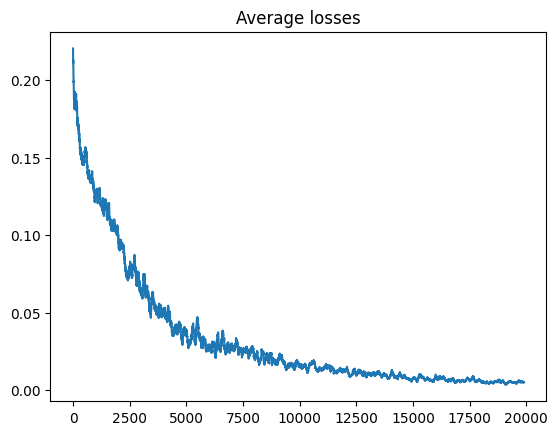

In [39]:
import numpy

# prepare neural network
nr_inputs  = S**2
nr_hidden1 = 20
nr_outputs = N_base_patterns
net = MLP(nr_inputs, nr_outputs, use_hidden_layer=True, nr_neurons_hidden1=nr_hidden1) # MLP
#net = MLP(nr_inputs, nr_outputs, use_hidden_layer=False) # Perceptron
print(net)

# prepare loss and optimizer
#loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

N_train_steps = 20000

losses = []
avg_losses = []
for train_step in range(N_train_steps):   
    
    # 1. get a random training sample
    #    consisting of an input vec and a teacher vec
    random_idx = numpy.random.randint(low=0, high=x_train.shape[0])  
    input_vec   = x_train[random_idx]
    teacher_vec = y_train[random_idx]
    
    # 2. sets gradients to 0 before calculating loss   
    # For: net.zero_grad() vs optim.zero_grad() see:    
    # https://stackoverflow.com/questions/61898668/net-zero-grad-vs-optim-zero-grad-pytorch
    #net.zero_grad()
    optimizer.zero_grad()

    # 3. feed forward step
    output_vec = net( input_vec )

    # 4. compute loss
    loss = loss_fn(output_vec, teacher_vec)
    
    # 5. apply this loss backwards thru the network's parameters
    loss.backward() 
    
    # 6. change weights, i.e.
    #    attempt to optimize weights to account for loss/gradients
    optimizer.step() 

    # 7. save loss
    loss_value = loss.detach().numpy()
    losses.append( loss_value )
    if len(losses)>100:
        avg_losses.append( numpy.mean(losses[-100:]) )
    
    # 8 show progress
    if train_step % 1000 == 0:
        print("train_step=", train_step)
        
import matplotlib.pyplot as plt
plt.plot( avg_losses )
plt.title("Average losses")
plt.show()

# Test how good the MLP can discriminate the base patterns

In [40]:
x_test

tensor([[-0.0191, -1.1428, -0.8079,  ...,  0.5557, -0.4062, -0.0577],
        [-0.3339,  0.3117, -1.2566,  ...,  1.8622,  1.0672,  0.3525],
        [-0.8037,  1.4583,  0.3285,  ..., -1.6856, -0.8577, -0.6882],
        ...,
        [ 0.4823, -0.5858, -0.5813,  ..., -0.8091,  0.3605,  0.0252],
        [-2.0648, -0.1385,  0.2938,  ..., -0.8368, -0.1994,  1.3036],
        [-0.0911,  1.2883,  0.2370,  ..., -0.1108,  0.6781,  2.6399]])

In [41]:
N_test_patterns = x_test.shape[0]
N_test_patterns

100

In [42]:
correct = 0
for test_pattern_idx in range(N_test_patterns):
    input_vec = x_test[test_pattern_idx]
    #print(input_vec)
    gt        = y_test[test_pattern_idx]
    
    pred = net(input_vec)
    pred_label = torch.argmax( pred )
    gt_label   = torch.argmax( gt )
    print()
    print( f"pred={pred}, pred_label={pred_label}" )
    print( f"gt  ={gt},   gt_label  ={gt_label}"   )
    
    if pred_label == gt_label:
        correct += 1
        
CCR = correct/N_test_patterns
print( f"Classified {CCR*100}% of the {N_test_patterns} test patterns correctly." ) 


pred=tensor([-0.0315, -0.0110,  0.9442, -0.0222,  0.1111], grad_fn=<AddBackward0>), pred_label=2
gt  =tensor([0., 0., 1., 0., 0.]),   gt_label  =2

pred=tensor([ 0.9238,  0.0570, -0.0654, -0.0468,  0.1173], grad_fn=<AddBackward0>), pred_label=0
gt  =tensor([1., 0., 0., 0., 0.]),   gt_label  =0

pred=tensor([-0.0978,  0.0056, -0.0553,  0.8264,  0.3171], grad_fn=<AddBackward0>), pred_label=3
gt  =tensor([0., 0., 0., 1., 0.]),   gt_label  =3

pred=tensor([ 0.9713, -0.0041,  0.0168,  0.0416, -0.0252], grad_fn=<AddBackward0>), pred_label=0
gt  =tensor([1., 0., 0., 0., 0.]),   gt_label  =0

pred=tensor([ 0.3918, -0.0532,  0.2430,  0.4189, -0.0171], grad_fn=<AddBackward0>), pred_label=3
gt  =tensor([0., 0., 0., 0., 1.]),   gt_label  =4

pred=tensor([ 1.1720, -0.0265,  0.0920,  0.1628, -0.4065], grad_fn=<AddBackward0>), pred_label=0
gt  =tensor([1., 0., 0., 0., 0.]),   gt_label  =0

pred=tensor([-0.1415,  1.0104, -0.0654, -0.0914,  0.2832], grad_fn=<AddBackward0>), pred_label=1
gt  =tensor([0

# Analysing the learned weights

In [43]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [44]:
net.fc1.weight.shape

torch.Size([20, 36])

In [45]:
net.fc1.weight

Parameter containing:
tensor([[ 6.4264e-03,  4.4631e-03, -2.1774e-03,  1.3875e-02, -7.4734e-03,
          8.9291e-03,  1.3012e-04, -1.5830e-03,  7.5183e-03, -6.5153e-03,
          2.4415e-03, -1.0849e-03,  1.9023e-03,  8.3983e-03, -2.6546e+00,
          2.5485e+00, -2.3088e-03,  4.8130e-03, -1.2009e-03,  2.0540e-03,
          3.1671e+00, -1.3186e+00, -2.0147e-03,  7.1198e-03,  1.3177e-03,
          4.3002e-03,  1.1167e-02,  6.3468e-03,  3.1025e-03, -6.7504e-03,
         -1.2123e-02, -1.4406e-02,  8.6464e-03,  4.5082e-03,  9.6505e-03,
          8.5798e-03],
        [ 1.2102e-01, -6.5012e-02, -5.5323e-02,  6.4320e-02,  1.2157e-01,
         -1.2138e-01, -8.3345e-02,  5.4457e-03,  5.2204e-02, -7.3021e-02,
         -2.1139e-01,  1.7588e-01, -1.0803e-01, -5.6062e-02,  9.9637e-01,
          2.8686e+00, -2.2001e-03,  2.3554e-01, -1.2713e-01,  1.8171e-01,
         -9.6578e-01, -7.5181e-01,  1.2655e-01,  1.4706e-01,  5.8377e-02,
         -1.3243e-01, -3.2812e-02, -7.6999e-02,  1.0370e-01,  2.162

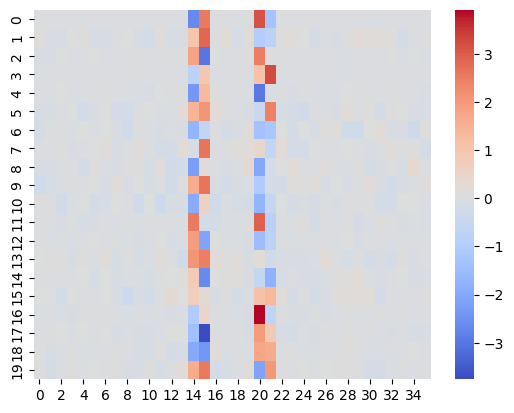

In [46]:
import seaborn
M = net.fc1.weight.detach().numpy()
seaborn.heatmap( M, cmap="coolwarm" )
plt.show()

In [47]:
numpy.arange(0,S**2).reshape(S,S)

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

We can see that some of the hidden neurons have learned to strongly weight the center input pixels 14,15,20,21.

And what about the output neurons?

In [48]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [49]:
net.fc2.weight.shape

torch.Size([5, 20])

In [50]:
net.fc2.weight

Parameter containing:
tensor([[-3.4167e-01,  1.1460e-01,  2.7065e-01, -4.2263e-01, -4.6056e-01,
          1.1971e-01, -2.0882e-01,  8.8963e-02, -1.6990e-01,  1.3204e-01,
         -1.4204e-01,  2.4896e-01,  3.6229e-01,  1.6959e-01,  8.1393e-02,
          9.8408e-02,  6.5684e-02, -1.4074e-01, -1.5698e-01,  1.6341e-01],
        [ 6.9937e-01, -4.8107e-03, -2.1997e-01, -4.4304e-01,  2.9186e-01,
         -1.3139e-02,  3.7006e-02, -1.0978e-03,  6.8573e-02,  5.8419e-03,
          3.5281e-02, -2.6671e-02, -1.3086e-01, -4.5464e-05, -1.1341e-02,
         -3.0700e-02,  9.7718e-02, -1.2674e-01, -9.6399e-02,  7.9521e-03],
        [ 2.1924e-01,  3.0530e-02,  4.2288e-01,  4.9324e-01, -4.5332e-01,
          6.2817e-02, -1.3555e-01,  1.6292e-02, -1.5961e-01,  1.3800e-02,
         -1.0500e-01,  1.2961e-01, -2.6721e-01,  7.1238e-02, -1.2417e-01,
          9.1154e-02,  2.4225e-01,  2.5911e-01,  3.1393e-01,  3.8424e-02],
        [-1.3983e-01,  1.5005e-01, -4.5696e-01,  5.3487e-01,  4.1350e-01,
          2.3

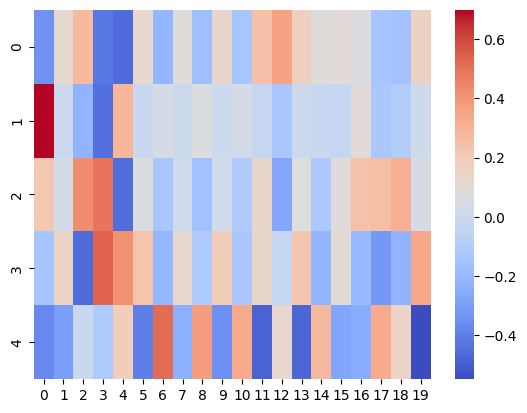

In [51]:
M = net.fc2.weight.detach().numpy()
seaborn.heatmap( M, cmap="coolwarm" )
plt.show()